## SVD/PCA/NMF and choosing the best k (reduced feature dimension)

In [1]:
import os
import sys
parent_dr = os.path.split(os.getcwd())[0]
if parent_dr not in sys.path:
    sys.path.append(parent_dr)

In [103]:
import scipy.sparse as sp
import pandas as pd
from sklearn.decomposition import NMF
import numpy.linalg as la
import matplotlib . pyplot as plt # plots
from time import time
from core.data.arxiv_data_io import *
from core.data.text.tf_idf_helpers import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#reading in the full arXiv subset df
file_name = "tokenized_arxiv_subset_15540.pkl"
full_path = os.path.join(parent_dr, "core", "resources", file_name)
data_df = pd.read_pickle(full_path)

In [5]:
data_df.head(n=2)

,id,authors,title,categories,abstract,update_dt,clean,tokens
0,0704.0648,Kaushik Majumdar,Behavioral response to strong aversive stimuli: A neurodynamical model,q-bio.NC,"In this paper a theoretical model of functioning of a neural circuit during a\nbehavioral response has been proposed. A neural circuit can be thought of as a\ndirected multigraph whose each vertex is a neuron and each edge is a synapse.\nIt has been assumed in this paper that the behavior of such circuits is\nmanifested through the collective behavior of neurons belonging to that\ncircuit. Behavioral information of each neuron is contained in the coefficients\nof the fast Fourier transform (FFT) over the output spike train. Those\ncoefficients form a vector in a multidimensional vector space. Behavioral\ndynamics of a neuronal network in response to strong aversive stimuli has been\nstudied in a vector space in which a suitable pseudometric has been defined.\nThe neurodynamical model of network behavior has been formulated in terms of\nexisting memory, synaptic plasticity and feelings. The model has an analogy in\nclassical electrostatics, by which the notion of force and potential energy has\nbeen introduced. Since the model takes input from each neuron in a network and\nproduces a behavior as the output, it would be extremely difficult or may even\nbe impossible to implement. But with the help of the model a possible\nexplanation for an hitherto unexplained neurological observation in human brain\nhas been offered. The model is compatible with a recent model of sequential\nbehavioral dynamics. The model is based on electrophysiology, but its relevance\nto hemodynamics has been outlined.\n",2007-05-23,in this paper a theoretical model of functioning of a neural circuit during a behavioral response has been proposed a neural circuit can be thought of as a directed multigraph whose each vertex is a neuron and each edge is a synapse it has been assumed in this paper that the behavior of such circuits is manifested through the collective behavior of neurons belonging to that circuit behavioral information of each neuron is contained in the coefficients of the fast fourier transform fft over the output spike train those coefficients form a vector in a multidimensional vector space behavioral dynamics of a neuronal network in response to strong aversive stimuli has been studied in a vector space in which a suitable pseudometric has been defined the neurodynamical model of network behavior has been formulated in terms of existing memory synaptic plasticity and feelings the model has an analogy in classical electrostatics by which the notion of force and potential energy has been introduced since the model takes input from each neuron in a network and produces a behavior as the output it would be extremely difficult or may even be impossible to implement but with the help of the model a possible explanation for an hitherto unexplained neurological observation in human brain has been offered the model is compatible with a recent model of sequential behavioral dynamics the model is based on electrophysiology but its relevance to hemodynamics has been outlined,"[paper, theoretical, model, functioning, neural, circuit, behavioral, response, propose, neural, circuit, think, direct, multigraph, vertex, neuron, edge, synapse, assume, paper, behavior, circuit, manifest, collective, behavior, neuron, belong, circuit, behavioral, information, neuron, contain, coefficient, fast, fourier, transform, fft, output, spike, train, coefficient, form, vector, multidimensional, vector, space, behavioral, dynamic, neuronal, network, response, strong, aversive, stimulus, study, vector, space, suitable, pseudometric, define, neurodynamical, model, network, behavior, formulate, term, exist, memory, synaptic, plasticity, feeling, model, analogy, classical, electrostatic, notion, force, potential, energy, introduce, model, take, input, neuron, network, produce, behavior, output, extremely, d

In [6]:
# splitting out the test and train dfs
train_df, test_df = sample_arxiv_data_by_category(data_df)
assert len(train_df)/len(data_df) == 0.8

In [7]:
print(f'The training df has dimensions {train_df.shape}')
print(f'The testing df has dimensions {test_df.shape}')

The training df has dimensions (12432, 9)
The testing df has dimensions (3108, 9)


### Compute TF-IDF Matrix

In [8]:
# fit the tfidf object
train_tokens = train_df['tokens']
tfidf_obj, index_to_word = fit_tfidf(train_df['tokens'])

In [9]:
print(f'tfidf_obj is a {type(tfidf_obj)} \n with a vocabulary of {len(index_to_word)} words')

tfidf_obj is a <class 'sklearn.feature_extraction.text.TfidfVectorizer'> 
 with a vocabulary of 30460 words


In [10]:
# generate the tfidf matrix for the training data
tfidf_train_matrix, index_to_doc = transform_tfidf(train_df,tfidf_obj=tfidf_obj)

In [11]:
print(f'The TF-IDF matrix is a sparse matrix with dimensions: {tfidf_train_matrix.shape}')

The TF-IDF matrix is a sparse matrix with dimensions: (12432, 30460)


### NMF Decomposition

In [66]:
n_samples, n_features = tfidf_train_matrix.shape
k = 100

In [67]:
t0 = time()
print("Fitting the NMF model with n_samples=%d and n_features=%d, and n_components=%d..."
      % (n_samples, n_features, k))

nmf_model = NMF(n_components = k, init='nndsvd', max_iter=1000,random_state=1)
W = nmf_model.fit_transform(tfidf_train_matrix)
H = nmf_model.components_
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model with n_samples=12432 and n_features=30460, and n_components...=100
done in 63.024s.


In [68]:
print(f'W with dimensions: {W.shape} \n H with dimensions:{H.shape}')

W with dimensions: (12432, 100) 
 H with dimensions:(100, 30460)


In [69]:
#info about the decomposition
print(f'Number of components: {nmf_model.n_components}')
print(f'Reconstruction error:{nmf_model.reconstruction_err_}')
print(f'Number of iterations to train:{nmf_model.n_iter_}')
print(f'Number of features seen during fit:{nmf_model.n_features_in_}')

Number of components: 100
Reconstruction error:101.3534406269884
Number of iterations to train:113
Number of features seen during fit:30460


In [94]:
def nmf_k_search(input_matrix, k_vals):
    """
    function for searching over different values of k
    """
    
    results = []
    for kval in k_vals:
        print(f"Now fitting NMF for k ={kval}...")
        
        t0=time()
        nmf_model = NMF(n_components=kval, init='nndsvd',
                        max_iter=1000,random_state=1)
        W = nmf_model.fit_transform(input_matrix)
        time_elapsed = time() - t0
        H = nmf_model.components_
        
        entry = [kval, nmf_model.reconstruction_err_,
                 nmf_model.n_iter_, time_elapsed]
        
        print(entry)
        
        results.append(entry)
        
    results_df = pd.DataFrame(results, columns=['k', 'Reconstruction Error',
                                                'Iterations to convergence',
                                                'Time to converge (secs)'])
    
    return results_df

In [99]:
kvals_simple = list(range(1,100,5))
simple_results = nmf_k_search(tfidf_train_matrix, kvals_simple)
simple_results

Now fitting NMF for k =1...
[1, 110.14452881562842, 7, 0.17669081687927246]
Now fitting NMF for k =6...
[6, 108.75391939598254, 50, 0.4690408706665039]
Now fitting NMF for k =11...
[11, 107.91344005912548, 84, 1.117257833480835]
Now fitting NMF for k =16...
[16, 107.2624211710831, 67, 1.189288854598999]
Now fitting NMF for k =21...
[21, 106.65444060143894, 102, 2.4404871463775635]
Now fitting NMF for k =26...
[26, 106.11959322978866, 72, 2.3896169662475586]
Now fitting NMF for k =31...
[31, 105.64561412128835, 216, 8.957004070281982]
Now fitting NMF for k =36...
[36, 105.23988031257993, 91, 5.475446939468384]
Now fitting NMF for k =41...
[41, 104.85066663282167, 191, 14.035443782806396]
Now fitting NMF for k =46...
[46, 104.47791521536506, 363, 32.964061975479126]
Now fitting NMF for k =51...
[51, 104.13117787951383, 274, 29.103681087493896]
Now fitting NMF for k =56...
[56, 103.79873967858894, 116, 15.55680799484253]
Now fitting NMF for k =61...
[61, 103.48323030595336, 117, 19.335510

,k,Reconstruction Error,Iterations to convergence,Time to converge (secs)
0,1,110.144529,7,0.176691
1,6,108.753919,50,0.469041
2,11,107.913440,84,1.117258
3,16,107.262421,67,1.189289
4,21,106.654441,102,2.440487
5,26,106.119593,72,2.389617
6,31,105.645614,216,8.957004
7,36,105.239880,91,5.475447
8,41,104.850667,191,14.035444
9,46,104.477915,363,32.964062


In [97]:
larger_k_vals = [150, 200, 300, 600, 1000, 15000]
larger_k_results = nmf_k_search(tfidf_train_matrix, larger_k_vals)
larger_k_results

Now fitting NMF for k =150...
[150, 99.06062880181726, 243, 277.3060259819031]
Now fitting NMF for k =200...
[200, 97.01359152285178, 305, 625.0525093078613]
Now fitting NMF for k =300...
[300, 93.5664692723195, 236, 2153.6644287109375]
Now fitting NMF for k =600...
[600, 85.76961768114077, 119, 1938.1206359863281]
Now fitting NMF for k =1000...
[1000, 77.81929157478947, 105, 4577.196753978729]
Now fitting NMF for k =15000...


ValueError: init = 'nndsvd' can only be used when n_components <= min(n_samples, n_features)

In [105]:
larger_results = [[150, 99.06062880181726, 243, 277.3060259819031],
                 [200, 97.01359152285178, 305, 625.0525093078613],
                 [300, 93.5664692723195, 236, 2153.6644287109375],
                 [600, 85.76961768114077, 119, 1938.1206359863281],
                 [1000, 77.81929157478947, 105, 4577.196753978729]]


larger_results_df = pd.DataFrame(larger_results, columns=['k', 'Reconstruction Error',
                                                'Iterations to convergence',
                                                'Time to converge (secs)'])
full_results_df = simple_results.append(larger_results_df)
full_results_df

,k,Reconstruction Error,Iterations to convergence,Time to converge (secs)
0,1,110.144529,7,0.176691
1,6,108.753919,50,0.469041
2,11,107.913440,84,1.117258
3,16,107.262421,67,1.189289
4,21,106.654441,102,2.440487
5,26,106.119593,72,2.389617
6,31,105.645614,216,8.957004
7,36,105.239880,91,5.475447
8,41,104.850667,191,14.035444
9,46,104.477915,363,32.964062


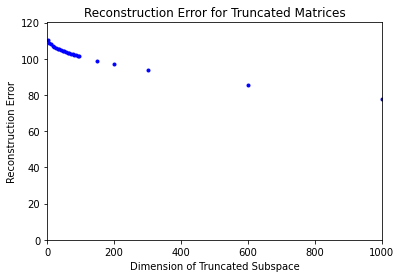

In [112]:
fig1 = plt.figure(23)
ax1 = plt.subplot(111)
ax1.plot(
    full_results_df.iloc[:,0], full_results_df.iloc[:,1], 'b.')
ax1.set_title('Reconstruction Error for Truncated Matrices')
ax1.set_xlabel('Dimension of Truncated Subspace')
ax1.set_ylabel('Reconstruction Error')
ax1.axis([0, 1001 , 0, max(full_results_df.iloc[:,1]) + 10])
plt.show()

### SVD

In [115]:
U, sigmas, V_T = la.svd(tfidf_train_matrix, full_matrices=False)


(12432, 30460)